### ACL Citations
- [Github](https://github.com/coastalcph/acl-citations)
- Data we used: `citations-all.tsv` and `citations-all.matched.tsv`.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import csv
import itertools as it
import pandas as pd
import researchpy as rp
import scipy
import seaborn as sns
sns.set()

CITATIONS_FILE="./data/citations-all.tsv"
CITATIONS_MATCH_FILE = "./data/citations-all.matched.tsv" 

#### Citations-all-Matched.TSV
- An ID for the extracted reference.
- The number of times this reference was cited in our dataset.
- The year of publication of the extracted reference.
- Its author list.
- Its title.
- A comma-separated list of ACL Anthology IDs of papers that were identified as citing this reference.

In [2]:
citations_matched_df = pd.read_csv(CITATIONS_MATCH_FILE, sep='\t')
print('\n------------------')
print('Citations-all.matched.tsv File:')
print(citations_matched_df.info())
print('------------------\n')


------------------
Citations-all.matched.tsv File:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72512 entries, 0 to 72511
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             72512 non-null  object
 1   num_cited      72512 non-null  int64 
 2   year           72512 non-null  int64 
 3   authors        70919 non-null  object
 4   title          72512 non-null  object
 5   citing_papers  72512 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.3+ MB
None
------------------



In [3]:
citations_matched_df.head(5)

,id,num_cited,year,authors,title,citing_papers
0,1964-0001,12,1964,"Y Bar-Hillel, M Perles, E Shamir",On formal properties of simple phrase structur...,"D10-1001,D11-1022,D11-1031,D11-1112,D11-1127,N..."
1,1964-0002,12,1964,F J Damerau,A technique for computer detection and correct...,"D10-1122,D14-1171,D15-1051,D15-1097,E12-1058,J..."
2,1964-0003,4,1964,M J D Powell,An efficient method for finding the minimum of...,"D11-1004,D13-1201,N19-1406,P12-2001"
3,1964-0004,1,1964,RE Wengert,A simple automatic derivative evaluation program.,D11-1058
4,1964-0005,1,1964,Eugene A Nida,Toward a Science of Translating.,D11-1084


In [26]:
citation_stats = citations_matched_df['num_cited'].describe()
print("Citation Count Statistics:\n", citation_stats)
print('\n------------------')
year_stats = citations_matched_df['year'].describe()
print("Year Statistics:\n", year_stats)
print('\n------------------')
total_citations = citations_matched_df['num_cited'].sum()
print(f"Total Citations: {total_citations}")
print('\n------------------')
unique_cited_papers = citations_matched_df['id'].nunique()
print(f"Total Unique Cited Papers: {unique_cited_papers}")

Citation Count Statistics:
 count    72512.000000
mean         3.468543
std         13.590233
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1190.000000
Name: num_cited, dtype: float64

------------------
Year Statistics:
 count    72512.000000
mean      2007.456518
std         15.076975
min       1080.000000
25%       2004.000000
50%       2010.000000
75%       2015.000000
max       2019.000000
Name: year, dtype: float64

------------------
Total Citations: 251511

------------------
Total Unique Cited Papers: 72512


In [8]:
# Adjust year distribution (Year >= 1900)
citations_matched_clean_df = citations_matched_df[citations_matched_df['year'] >= 1900]

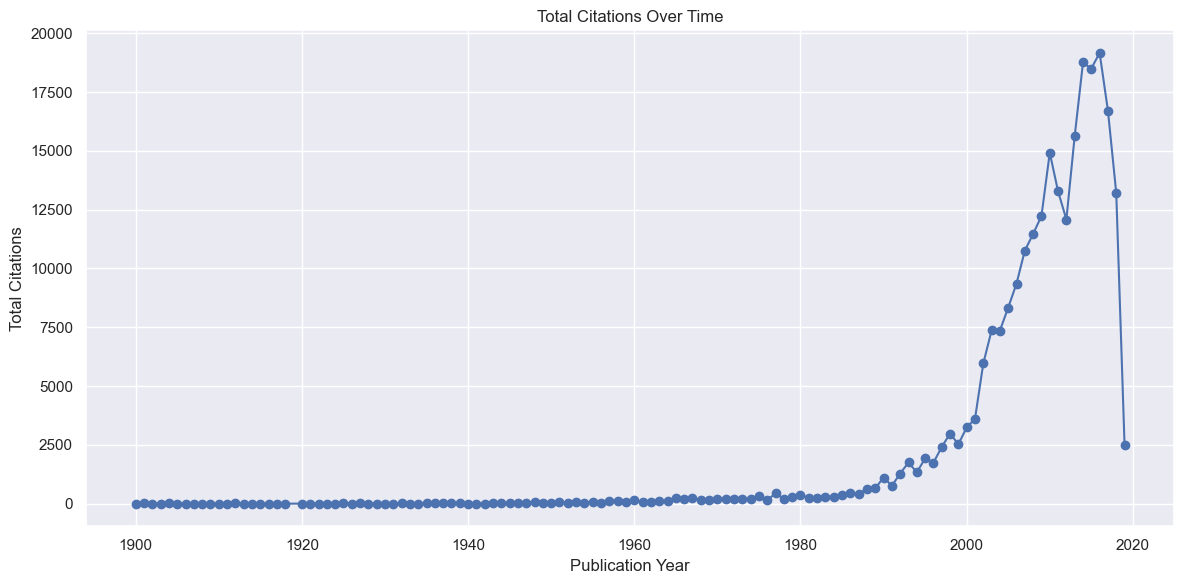

In [9]:
# Group by year and sum citations
citations_per_year = citations_matched_clean_df.groupby('year')['num_cited'].sum()
plt.figure(figsize=(12, 6))
plt.plot(citations_per_year.index, citations_per_year.values, marker='o')
plt.xlabel('Publication Year')
plt.ylabel('Total Citations')
plt.title('Total Citations Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Citations-all.TSV
- The ACL Anthology ID of the paper the reference is extracted from.
- The year of publication of the extracted reference.
- The author list of the extracted reference.
- The title of the extracted reference.

In [11]:
column_names = ['source_id', 'year', 'authors', 'title']
citations_df = pd.read_csv(CITATIONS_FILE, sep='\t', names=column_names, header=None)
print('\n------------------')
print('Citations-all.tsv File:')
print(citations_df.info())
print('------------------\n')


------------------
Citations-all.tsv File:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251511 entries, 0 to 251510
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   source_id  251511 non-null  object
 1   year       251511 non-null  int64 
 2   authors    249139 non-null  object
 3   title      251511 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB
None
------------------



In [65]:
citations_df.head(5)

,source_id,year,authors,title
0,D10-1001,1964,"Y Bar-Hillel, M Perles, E Shamir",On formal properties of simple phrase structur...
1,D10-1001,2008,"X Carreras, M Collins, T Koo","TAG, dynamic programming, and the perceptron f..."
2,D10-1001,2007,X Carreras,Experiments with a higher-order projective dep...
3,D10-1001,2002,M Collins,Discriminative training methods for hidden mar...
4,D10-1001,2003,M Collins,Head-driven statistical models for natural lan...


# WHAT WE NEED IN THIS DATASET
Definition: 
- `source` = **Paper A**, `target` = **Paper B**
- **B(Paper) -- cited --> A(References)**

Fields:
- **id** (A)
- **num_cited** (A)
- **year** (A)
- **authors** (A)
- **title** (A)
- **source_id** (A; ACL Format, can used for acl.get(`source_id`))
- **citing_papers** (All Bs)

In [12]:
df = pd.merge(
    citations_matched_df,
    citations_df[['source_id', 'title']],
    on='title',
    how='left')
df.head()

,id,num_cited,year,authors,title,citing_papers,source_id
0,1964-0001,12,1964,"Y Bar-Hillel, M Perles, E Shamir",On formal properties of simple phrase structur...,"D10-1001,D11-1022,D11-1031,D11-1112,D11-1127,N...",D10-1001
1,1964-0001,12,1964,"Y Bar-Hillel, M Perles, E Shamir",On formal properties of simple phrase structur...,"D10-1001,D11-1022,D11-1031,D11-1112,D11-1127,N...",D11-1031
2,1964-0001,12,1964,"Y Bar-Hillel, M Perles, E Shamir",On formal properties of simple phrase structur...,"D10-1001,D11-1022,D11-1031,D11-1112,D11-1127,N...",D11-1112
3,1964-0001,12,1964,"Y Bar-Hillel, M Perles, E Shamir",On formal properties of simple phrase structur...,"D10-1001,D11-1022,D11-1031,D11-1112,D11-1127,N...",D11-1127
4,1964-0001,12,1964,"Y Bar-Hillel, M Perles, E Shamir",On formal properties of simple phrase structur...,"D10-1001,D11-1022,D11-1031,D11-1112,D11-1127,N...",N10-1130


In [14]:
print('\n------------------')
print(citations_matched_df.info())
print('\n------------------')
citation_stats = df['num_cited'].describe()
print("Citation Count Statistics:\n", citation_stats)
print('\n------------------')
year_stats = df['year'].describe()
print("Year Statistics:\n", year_stats)
print('\n------------------')
total_citations = df['num_cited'].sum()
print(f"Total Citations: {total_citations}")
print('\n------------------')
unique_cited_papers = df['id'].nunique()
print(f"Total Unique Cited Papers: {unique_cited_papers}")


------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72512 entries, 0 to 72511
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             72512 non-null  object
 1   num_cited      72512 non-null  int64 
 2   year           72512 non-null  int64 
 3   authors        70919 non-null  object
 4   title          72512 non-null  object
 5   citing_papers  72512 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.3+ MB
None

------------------
Citation Count Statistics:
 count    314416.000000
mean         25.469229
std          90.517659
min           1.000000
25%           1.000000
50%           2.000000
75%          11.000000
max        1190.000000
Name: num_cited, dtype: float64

------------------
Year Statistics:
 count    314416.000000
mean       2008.834493
std          12.742865
min        1080.000000
25%        2006.000000
50%        2011.000000
75%        2015.000000
max       

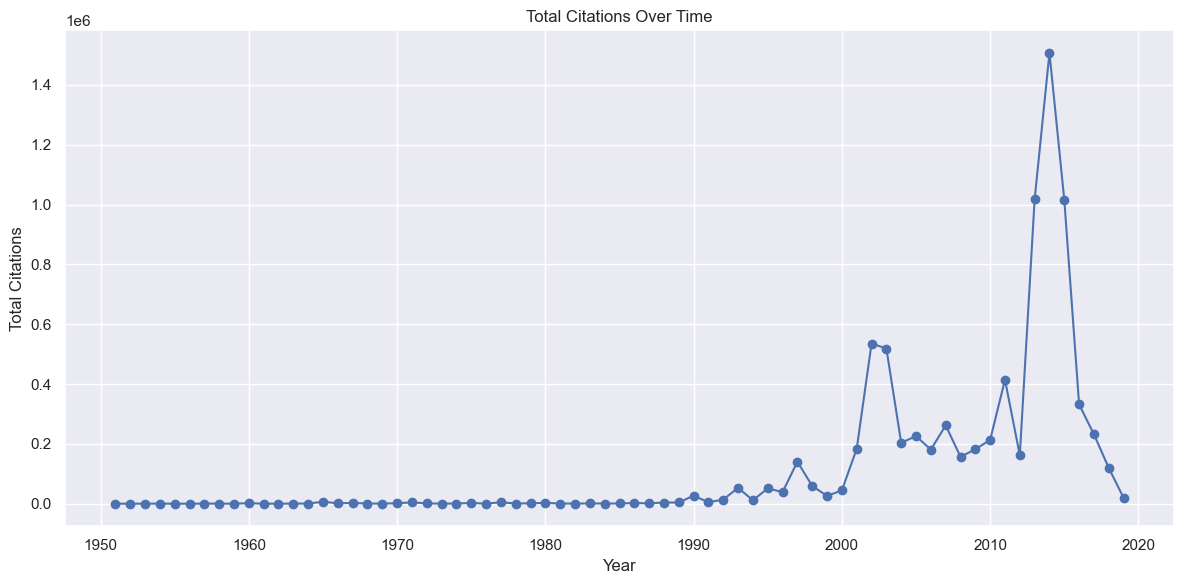

In [20]:
# Sum citations by publication year
citations_over_time = df[df['year'] > 1950].groupby('year')['num_cited'].sum()
plt.figure(figsize=(12, 6))
plt.plot(citations_over_time.index, citations_over_time.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Total Citations')
plt.title('Total Citations Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


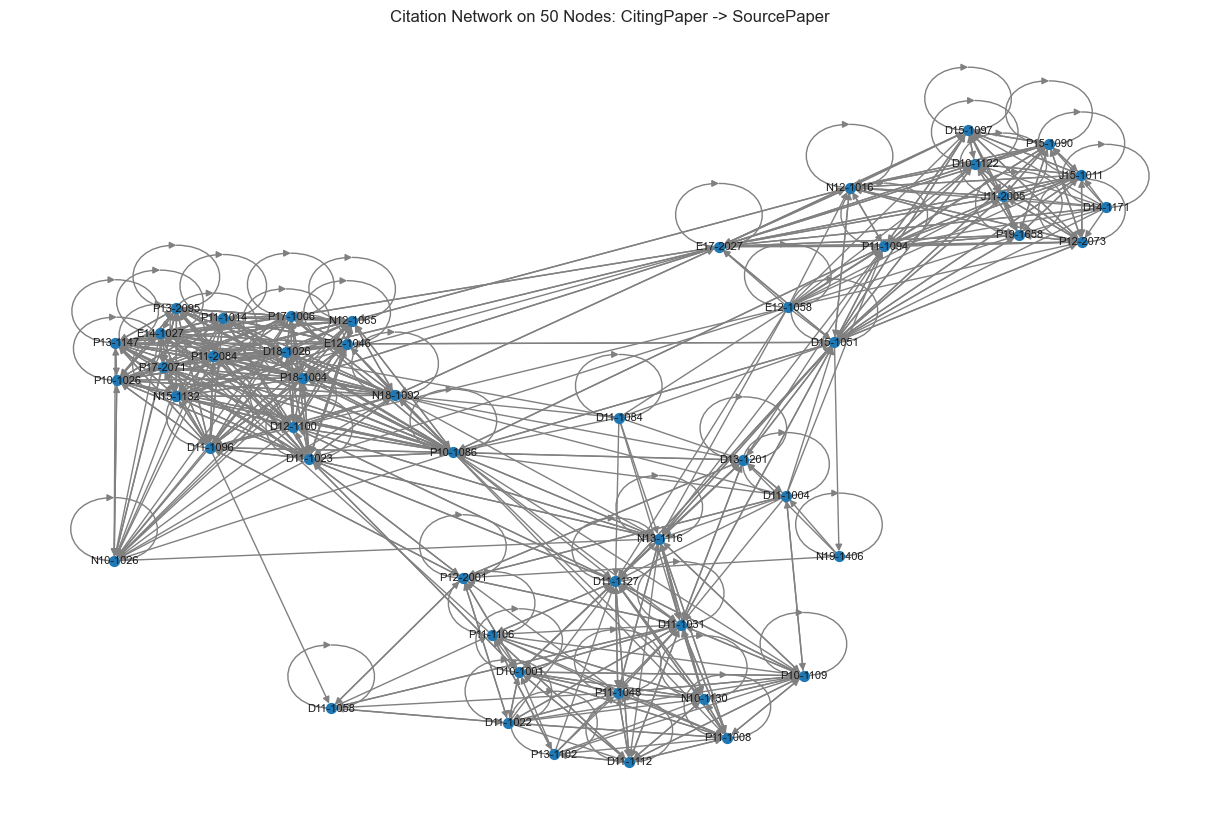

In [27]:
import networkx as nx

NUM_NODE = 50
# Initialize a directed graph
G = nx.DiGraph()

# Add edges: source paper <- citing paper
for index, row in df.iterrows():
    source = row['source_id']
    citing_papers = str(row['citing_papers']).split(',')
    for citing_paper in citing_papers:
        citing_paper = citing_paper.strip()
        if citing_paper:
            G.add_edge(citing_paper, source)

sample_graph = G.subgraph(list(G.nodes)[:NUM_NODE])
plt.figure(figsize=(12, 8))
nx.draw(sample_graph, with_labels=True, node_size=NUM_NODE, edge_color='gray', font_size=8)
plt.title(f'Citation Network on {NUM_NODE} Nodes: CitingPaper -> SourcePaper')
plt.show()
